# Evaluation of Machine Learning Models for Supervised Fraud Detection

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
import warnings

import xgboost as XGBClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
import lightgbm as lgb

%matplotlib inline
start_time = dt.datetime.now()

### Variable Selection - Filter

In [2]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 20% of the original # variables
num_filter = 20
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper somewhat above this saturation point, not more than twice
num_wrapper = 10
balance = 0
detect_rate = .03
index_name = 'index'
y_name = 'Class'
good_label = 0
bad_label = 1

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'creditcard_kaggle.csv'
    df = pd.read_csv('creditcard_kaggle.csv')
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on creditcard_kaggle.csv size is (284807, 32)
creditcard_kaggle.csv    variable  filter score
30    Class      1.000000
14      V14      0.885036
10      V10      0.853200
12      V12      0.837283
11      V11      0.822894
3        V3      0.811939
17      V17      0.799022
4        V4      0.787736
16      V16      0.758217
7        V7      0.746066
2        V2      0.718836
9        V9      0.648143
27      V27      0.635189
6        V6      0.618662
21      V21      0.613736
18      V18      0.603236
5        V5      0.559780
1        V1      0.554768
8        V8      0.463035
28      V28      0.454643
CPU times: user 1.32 s, sys: 88.1 ms, total: 1.41 s
Wall time: 1.41 s


In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)
filter_score

,variable,filter score
0,Class,1.000000
1,V14,0.885036
2,V10,0.853200
3,V12,0.837283
4,V11,0.822894
5,V3,0.811939
6,V17,0.799022
7,V4,0.787736
8,V16,0.758217
9,V7,0.746066


In [5]:
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['V14', 'V10', 'V12', 'V11', 'V3', 'V17', 'V4', 'V16', 'V7', 'V2', 'V9', 'V27', 'V6', 'V21', 'V18', 'V5', 'V1', 'V8', 'V28', 'V20', 'V19', 'Amount']


In [6]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,V14,V10,V12,V11,V3,V17,V4,V16,V7,V2,V9,V27,V6,V21,V18,V5,V1,V8,V28,V20
index,,,,,,,,,,,,,,,,,,,,
2995,-0.610918,-0.503940,-1.075066,-0.028662,-0.144504,0.912898,1.409172,0.508495,0.160138,0.523792,0.217257,0.018457,-1.434964,-0.054926,0.619784,-0.320571,1.215314,-0.144819,0.050005,-0.252037
2996,0.195609,-0.478969,-0.372919,-0.501889,1.911303,-0.455845,-0.272867,0.304087,0.715814,1.011602,-0.423164,-0.297565,-0.922228,-0.176070,-0.324257,0.081522,-0.971650,-0.135522,0.104088,-0.098440
2997,-1.076278,0.914213,0.277212,-0.056049,2.178270,0.163702,1.351661,-1.598118,1.044716,0.012962,0.288101,-0.949933,-0.167862,-0.219997,-0.933991,1.462775,-1.055610,-0.969907,-0.500359,0.151248
2998,-1.076278,0.914213,0.277212,-0.056049,2.178270,0.163702,1.351661,-1.598118,1.044716,0.012962,0.288101,-0.949933,-0.167862,-0.219997,-0.933991,1.462775,-1.055610,-0.969907,-0.500359,0.151248
2999,-1.077164,0.912679,0.275956,-0.055570,2.175615,0.163085,1.350192,-1.597053,1.057312,0.018941,0.287355,-0.946454,-0.158682,-0.221783,-0.934231,1.449274,-1.051814,-0.972456,-0.501829,0.146337


In [7]:
Y = Y.values
Y_save = Y.copy()
X = df_keep

### Variable Selection - Wrapper

In [8]:
def fdr(classifier, x, y, cutoff=detect_rate):
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:   
        y_prob = y_prob[:, -1:] 
    num_fraud = len(y[y == 1])  
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [9]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [10]:
%%time
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=7) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=10,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=10,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

/Users/oliverdobbs/miniforge3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/oliverdobbs/miniforge3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/oliverdobbs/miniforge3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/oliverdobbs/miniforge3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed whe

CPU times: user 704 ms, sys: 613 ms, total: 1.32 s
Wall time: 29.5 s


SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=7),
                          k_features=10, n_jobs=-1,
                          scoring=<function fdr at 0x15d28f670>)

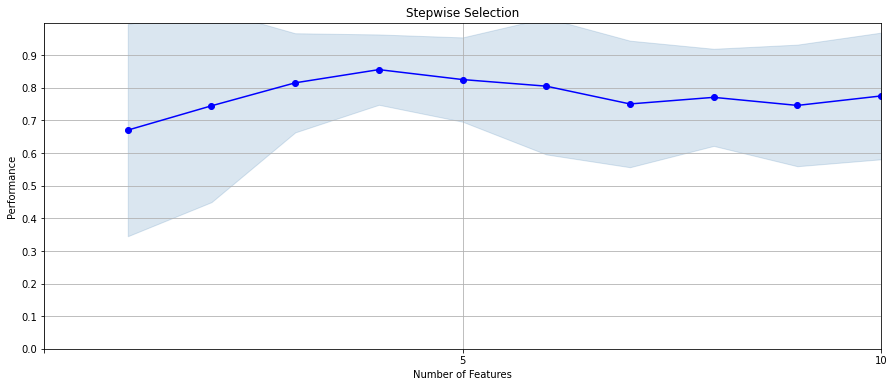

In [11]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.show()

In [12]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [13]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names']))[0]

In [14]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(5,)","[0.75, 0.75, 1.0, 0.05, 0.05, 0.90476190476190...",0.670476,"(V17,)",0.241606,0.325302,0.108434,1.0,V17
2,"(3, 5)","[0.25, 0.15, 1.0, 0.95, 0.9, 1.0, 1.0, 0.65, 0...",0.745,"(V11, V17)",0.219352,0.295339,0.098446,2.0,V11
3,"(1, 3, 5)","[0.95, 0.85, 1.0, 0.95, 0.7, 0.904761904761904...",0.815476,"(V10, V11, V17)",0.112902,0.152013,0.050671,3.0,V10
4,"(1, 3, 5, 10)","[0.9, 0.8, 0.95, 0.95, 0.85, 0.809523809523809...",0.855952,"(V10, V11, V17, V9)",0.08009,0.107835,0.035945,4.0,V9
5,"(1, 3, 5, 10, 12)","[1.0, 0.8, 0.9, 1.0, 0.7, 0.9047619047619048, ...",0.825476,"(V10, V11, V17, V9, V6)",0.095975,0.129223,0.043074,5.0,V6
6,"(1, 3, 5, 10, 12, 17)","[0.95, 0.55, 0.8, 0.95, 1.0, 0.952380952380952...",0.805238,"(V10, V11, V17, V9, V6, V8)",0.155429,0.209271,0.069757,6.0,V8
7,"(1, 3, 5, 10, 12, 13, 17)","[1.0, 0.65, 0.6, 1.0, 0.85, 0.8571428571428571...",0.750714,"(V10, V11, V17, V9, V6, V21, V8)",0.144108,0.19403,0.064677,7.0,V21
8,"(1, 3, 4, 5, 10, 12, 13, 17)","[1.0, 0.55, 0.85, 1.0, 0.6, 0.8095238095238095...",0.770952,"(V10, V11, V3, V17, V9, V6, V21, V8)",0.110575,0.14888,0.049627,8.0,V3
9,"(1, 3, 4, 5, 9, 10, 12, 13, 17)","[1.0, 0.9, 0.7, 1.0, 0.8, 0.7619047619047619, ...",0.74619,"(V10, V11, V3, V17, V2, V9, V6, V21, V8)",0.138451,0.186413,0.062138,9.0,V2
10,"(1, 3, 4, 5, 9, 10, 11, 12, 13, 17)","[0.95, 0.6, 0.35, 1.0, 0.9, 0.9523809523809523...",0.775238,"(V10, V11, V3, V17, V2, V9, V27, V6, V21, V8)",0.144226,0.194188,0.064729,10.0,V27


In [15]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1     V17
2     V11
3     V10
4      V9
5      V6
6      V8
7     V21
8      V3
9      V2
10    V27
Name: variable name, dtype: object

In [16]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score.head()

,filter score
variable,
V14,0.885036
V10,0.853200
V12,0.837283
V11,0.822894
V3,0.811939


In [17]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
V17
V11
V10
V9
V6


In [18]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted.head()

,wrapper order,variable,filter score
0,1,V17,0.799022
1,2,V11,0.822894
2,3,V10,0.853200
3,4,V9,0.648143
4,5,V6,0.618662


In [19]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['V17',
 'V11',
 'V10',
 'V9',
 'V6',
 'V8',
 'V21',
 'V3',
 'V2',
 'V27',
 'index',
 'Class']

In [20]:
df = pd.read_csv(file_name)
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(284807, 12)


In [21]:
df_keep.to_csv('vars_final.csv',index=False)

In [22]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:33.752141


## Modeling

In [23]:
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(284807, 12)


,V17,V11,V10,V9,V6,V8,V21,V3,V2,V27,index,Class
0,0.207971,-0.551600,0.090794,0.363787,0.462388,0.098698,-0.018307,2.536347,-0.072781,0.133558,0,0
1,-0.114805,1.612727,-0.166974,-0.255425,-0.082361,0.085102,-0.225775,0.166480,0.266151,-0.008983,1,0
2,1.109969,0.624501,0.207643,-1.514654,1.800499,0.247676,0.247998,1.773209,-1.340163,-0.055353,2,0
3,-0.684093,-0.226487,-0.054952,-1.387024,1.247203,0.377436,-0.108300,1.792993,-0.185226,0.062723,3,0
4,-0.237033,-0.822843,0.753074,0.817739,0.095921,-0.270533,-0.009431,1.548718,0.877737,0.219422,4,0


In [24]:
final_vars = pd.read_csv('final_vars_list.csv')
final_vars

,variable name
0,V17
1,V11
2,V10
3,V9
4,V6
5,V8
6,V21
7,V3
8,V2
9,V27


In [25]:
vars.rename(columns={'index':'Index'},inplace=True)
numvars = min(15,len(final_vars))
final_vars_list = ['Index','Class']
for i in range(numvars):
    final_vars_list.append(final_vars.iloc[i]['variable name'])
#vars = vars.filter(final_vars_list,axis=1)    
final_vars_list

['Index',
 'Class',
 'V17',
 'V11',
 'V10',
 'V9',
 'V6',
 'V8',
 'V21',
 'V3',
 'V2',
 'V27']

In [26]:
Clip = 10

In [27]:
vars

,V17,V11,V10,V9,V6,V8,V21,V3,V2,V27,Index,Class
0,0.207971,-0.551600,0.090794,0.363787,0.462388,0.098698,-0.018307,2.536347,-0.072781,0.133558,0,0
1,-0.114805,1.612727,-0.166974,-0.255425,-0.082361,0.085102,-0.225775,0.166480,0.266151,-0.008983,1,0
2,1.109969,0.624501,0.207643,-1.514654,1.800499,0.247676,0.247998,1.773209,-1.340163,-0.055353,2,0
3,-0.684093,-0.226487,-0.054952,-1.387024,1.247203,0.377436,-0.108300,1.792993,-0.185226,0.062723,3,0
4,-0.237033,-0.822843,0.753074,0.817739,0.095921,-0.270533,-0.009431,1.548718,0.877737,0.219422,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1.991691,-1.593105,4.356170,1.914428,-2.606837,7.305334,0.213454,-9.834783,10.071785,0.943651,284802,0
284803,-0.025693,-0.150189,-0.975926,0.584800,1.058415,0.294869,0.214205,2.035030,-0.055080,0.068472,284803,0
284804,0.313502,0.411614,-0.484782,0.432454,3.031260,0.708417,0.232045,-3.249640,-0.301254,0.004455,284804,0
284805,0.509928,-1.933849,-0.399126,0.392087,0.623708,0.679145,0.265245,0.702510,0.530483,0.108821,284805,0


In [28]:
record_save = vars['Index']
Y_save = pd.DataFrame(vars.loc[:,'Class'])

In [29]:
X = vars.drop(columns = ['Index','Class'])

In [30]:
# Reduce outliers
cols = X.columns
X.loc[:,cols] = X[cols].clip(upper=Clip)
X.loc[:,cols] = X[cols].clip(lower=-1*Clip)
# X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,V17,V11,V10,V9,V6,V8,V21,V3,V2,V27
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,0.003288,-0.000043,0.000404,0.000005,-0.000306,0.010290,-0.001150,0.005494,0.014665,-0.000046
std,0.793767,1.020259,1.061108,1.098028,1.309272,1.022158,0.673689,1.457550,1.468386,0.397526
min,-10.000000,-4.797473,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-0.483748,-0.762494,-0.535426,-0.643098,-0.768296,-0.208630,-0.228395,-0.890365,-0.598550,-0.070840
50%,-0.065676,-0.032757,-0.092917,-0.051429,-0.274187,0.022358,-0.029450,0.179846,0.065486,0.001342
75%,0.399675,0.739593,0.453923,0.597139,0.398565,0.327346,0.186377,1.027196,0.803724,0.091045
max,9.253526,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.382558,10.000000,10.000000


In [31]:
oot_recnum=84806
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

In [32]:
niter = 0
nitermax = 10
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None

### Regularization

In [33]:
alphas = 10**np.linspace(7,-2,100)*0.5

In [34]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [35]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(100, 10)

Text(0.5, 1.0, 'Ridge')

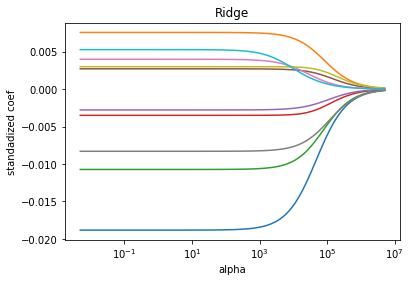

In [36]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha') 
plt.ylabel('standadized coef') 
plt.title('Ridge')

In [37]:
alphas = 10**np.linspace(2,-8,100)*0.5

In [38]:
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

Selected Features: ['V17', 'V11', 'V10', 'V9', 'V6', 'V8', 'V21', 'V3', 'V2', 'V27']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


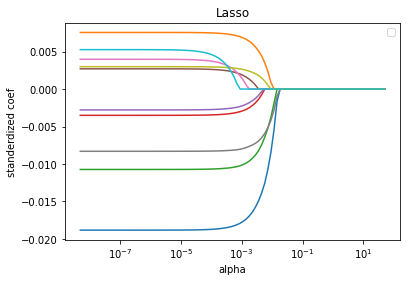

In [39]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()

## Models

In [40]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

### Logistic Regression

In [41]:
%%time

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=100)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Class'] = Y_trn_save['Class']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Class'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Class'] = Y_tst['Class']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Class'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Class'] = Y_oot['Class']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Class'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.9027777777777778 0.85 0.7881944444444444
1 0.8979591836734694 0.8596491228070176 0.7847222222222222
2 0.9 0.8518518518518519 0.78125
3 0.9136690647482014 0.8153846153846154 0.7847222222222222
4 0.8962962962962963 0.855072463768116 0.78125
5 0.8851351351351351 0.875 0.7847222222222222
6 0.8936170212765957 0.8888888888888888 0.8090277777777778
7 0.8986486486486487 0.875 0.7916666666666666
8 0.8978102189781022 0.8656716417910447 0.7881944444444444
9 0.8774193548387097 0.9183673469387755 0.7847222222222222
trn    0.896333
tst    0.865489
oot    0.787847
dtype: float64
CPU times: user 3.03 s, sys: 1.59 s, total: 4.62 s
Wall time: 1.27 s


### Decision Tree

In [42]:
%%time

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(max_depth=3,min_samples_split=2000, max_features = 9)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Class'] = Y_trn_save['Class']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Class'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Class'] = Y_tst['Class']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Class'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Class'] = Y_oot['Class']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Class'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.8417721518987342 0.9130434782608695 0.6701388888888888
1 0.8666666666666667 0.8695652173913043 0.6875
2 0.8689655172413793 0.8813559322033898 0.6631944444444444
3 0.8698630136986302 0.9137931034482759 0.6631944444444444
4 0.8676470588235294 0.8676470588235294 0.6840277777777778
5 0.8758620689655172 0.864406779661017 0.6666666666666666
6 0.869281045751634 0.8431372549019608 0.5972222222222222
7 0.8832116788321168 0.835820895522388 0.6631944444444444
8 0.8551724137931035 0.8305084745762712 0.6597222222222222
9 0.855072463768116 0.803030303030303 0.6145833333333334
trn    0.865351
tst    0.862231
oot    0.656944
dtype: float64
CPU times: user 2.02 s, sys: 298 ms, total: 2.32 s
Wall time: 1.89 s


### Random Forest

In [43]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_split=1000,max_features=5)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Class'] = Y_trn_save['Class']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Class'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Class'] = Y_tst['Class']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Class'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Class'] = Y_oot['Class']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Class'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.8783783783783784 0.9285714285714286 0.7916666666666666
1 0.8848920863309353 0.9076923076923077 0.7986111111111112
2 0.8783783783783784 0.9107142857142857 0.8020833333333334
3 0.9084967320261438 0.8627450980392157 0.7881944444444444
4 0.8896551724137931 0.9152542372881356 0.7951388888888888
5 0.9130434782608695 0.8636363636363636 0.8229166666666666
6 0.8936170212765957 0.8888888888888888 0.7881944444444444
7 0.9071428571428571 0.859375 0.8159722222222222
8 0.8993288590604027 0.8727272727272727 0.7986111111111112
9 0.9020979020979021 0.8852459016393442 0.8020833333333334
trn    0.895503
tst    0.889485
oot    0.800347
dtype: float64
CPU times: user 57.6 s, sys: 923 ms, total: 58.5 s
Wall time: 58.6 s


### LightGBM

In [44]:
%%time

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(num_leaves=20,n_estimators=100, max_depth=3, learning_rate=0.01)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Class'] = Y_trn_save['Class']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Class'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Class'] = Y_tst['Class']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Class'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Class'] = Y_oot['Class']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Class'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.934640522875817 0.8823529411764706 0.8368055555555556
1 0.910958904109589 0.9137931034482759 0.8506944444444444
2 0.9230769230769231 0.9180327868852459 0.8611111111111112
3 0.9133333333333333 0.9259259259259259 0.8402777777777778
4 0.920863309352518 0.8923076923076924 0.8368055555555556
5 0.9642857142857143 0.8125 0.8368055555555556
6 0.9407407407407408 0.8695652173913043 0.8506944444444444
7 0.9219858156028369 0.9206349206349206 0.8472222222222222
8 0.900709219858156 0.9523809523809523 0.84375
9 0.9281045751633987 0.8823529411764706 0.84375
trn    0.925870
tst    0.896985
oot    0.844792
dtype: float64
CPU times: user 17.7 s, sys: 6.54 s, total: 24.2 s
Wall time: 5.87 s


### Neural Networks

In [45]:
%%time

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(100),solver='adam',activation='relu',
                          max_iter=100,learning_rate_init=.0001)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Class'] = Y_trn_save['Class']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Class'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Class'] = Y_tst['Class']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Class'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Class'] = Y_oot['Class']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Class'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.8985507246376812 0.803030303030303 0.7118055555555556
1 0.9029850746268657 0.8857142857142857 0.7361111111111112
2 0.875 0.8970588235294118 0.7256944444444444
3 0.8796992481203008 0.9014084507042254 0.7395833333333334
4 0.8529411764705882 0.9411764705882353 0.7361111111111112
5 0.8913043478260869 0.8939393939393939 0.7291666666666666
6 0.9264705882352942 0.8088235294117647 0.7534722222222222
7 0.868421052631579 0.9615384615384616 0.7569444444444444
8 0.8591549295774648 0.9354838709677419 0.7152777777777778
9 0.8913043478260869 0.8787878787878788 0.7604166666666666
trn    0.884583
tst    0.890696
oot    0.736458
dtype: float64
CPU times: user 2min 32s, sys: 1min 23s, total: 3min 55s
Wall time: 1min 5s


### Gradient Boosting Classifier

In [46]:
%%time

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(learning_rate=0.01,max_depth=6,n_estimators=50, min_samples_split=1000,subsample=1)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Class'] = Y_trn_save['Class']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Class'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Class'] = Y_tst['Class']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Class'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Class'] = Y_oot['Class']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Class'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.9230769230769231 0.9054054054054054 0.8159722222222222
1 0.9393939393939394 0.875 0.8125
2 0.9357142857142857 0.890625 0.7743055555555556
3 0.9424460431654677 0.8923076923076924 0.8055555555555556
4 0.9285714285714286 0.90625 0.7673611111111112
5 0.9117647058823529 0.8529411764705882 0.6736111111111112
6 0.9071428571428571 0.9375 0.78125
7 0.94 0.8888888888888888 0.8090277777777778
8 0.958041958041958 0.819672131147541 0.7673611111111112
9 0.9205298013245033 0.9433962264150944 0.8090277777777778
trn    0.930668
tst    0.891199
oot    0.781597
dtype: float64
CPU times: user 2min 33s, sys: 946 ms, total: 2min 34s
Wall time: 2min 34s


### KNeigbours Classifer

In [47]:
%%time

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = KNeighborsClassifier(n_neighbors=300, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Class'] = Y_trn_save['Class']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Class'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Class'] = Y_tst['Class']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Class'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Class'] = Y_oot['Class']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Class'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['KNN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.9640287769784173 0.9230769230769231 0.8020833333333334
1 0.9668874172185431 0.8679245283018868 0.8055555555555556
2 0.9444444444444444 0.9166666666666666 0.8020833333333334
3 0.9536423841059603 0.9245283018867925 0.7986111111111112
4 0.9477124183006536 0.8823529411764706 0.7951388888888888
5 0.9931506849315068 0.8620689655172413 0.8125
6 0.9626865671641791 0.9142857142857143 0.8020833333333334
7 0.9607843137254902 0.8823529411764706 0.8333333333333334
8 0.9440559440559441 0.9016393442622951 0.8055555555555556
9 0.958041958041958 0.9180327868852459 0.7951388888888888
trn    0.959543
tst    0.899293
oot    0.805208
dtype: float64
CPU times: user 12min 35s, sys: 4.87 s, total: 12min 39s
Wall time: 12min 40s


### Stacking Classifier

In [48]:
%%time

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    estimators = [
                 ('rf_1', RandomForestClassifier(n_estimators=100,max_depth=2,min_samples_split=2000,max_features=5)),
                 ('rf_2', LogisticRegression(max_iter=100))             
                ]


    model = StackingClassifier(estimators=estimators,stack_method='auto', n_jobs=None, passthrough=False, verbose=0)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Class'] = Y_trn_save['Class']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Class'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Class'] = Y_tst['Class']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Class'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Class'] = Y_oot['Class']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Class']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Class'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['STC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.875 0.9117647058823529 0.8020833333333334
1 0.92 0.7962962962962963 0.7951388888888888
2 0.910958904109589 0.8448275862068966 0.7986111111111112
3 0.8707482993197279 0.9298245614035088 0.7951388888888888
4 0.8840579710144928 0.8939393939393939 0.7951388888888888
5 0.9104477611940298 0.8428571428571429 0.7916666666666666
6 0.8741258741258742 0.9180327868852459 0.7916666666666666
7 0.8695652173913043 0.9090909090909091 0.8020833333333334
8 0.8943661971830986 0.8548387096774194 0.8020833333333334
9 0.9121621621621622 0.8214285714285714 0.7986111111111112
trn    0.892143
tst    0.872290
oot    0.797222
dtype: float64
CPU times: user 3min 32s, sys: 20.8 s, total: 3min 53s
Wall time: 3min 13s


## Comparison

In [49]:
model_counter

8

In [50]:
df = Modeling_output.dropna()
df.head()

,Model,Trn,Tst,OOT
0,log reg,0.902778,0.85,0.788194
1,log reg,0.897959,0.859649,0.784722
2,log reg,0.9,0.851852,0.78125
3,log reg,0.913669,0.815385,0.784722
4,log reg,0.896296,0.855072,0.78125


In [51]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.902778
1,log reg,Trn,0.897959
2,log reg,Trn,0.9
3,log reg,Trn,0.913669
4,log reg,Trn,0.896296


In [52]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.902778
1,log reg,Trn,0.897959
2,log reg,Trn,0.9
3,log reg,Trn,0.913669
4,log reg,Trn,0.896296


In [53]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
             mean       std      mean       std      mean       std
Model                                                              
DT       0.865351  0.011788  0.862231  0.035382  0.656944  0.028717
GBC      0.930668  0.015464  0.891199  0.036736  0.781597  0.042603
KNN      0.959543  0.014375  0.899293  0.023639  0.805208  0.011156
LGBM     0.925870  0.017762  0.896985  0.038774  0.844792  0.007858
NN       0.884583  0.022119  0.890696  0.051955  0.736458  0.016728
RF       0.895503  0.012503  0.889485  0.024862  0.800347  0.011370
STC      0.892143  0.019783  0.872290  0.046032  0.797222  0.004076
log reg  0.896333  0.009754  0.865489  0.027087  0.787847  0.008094

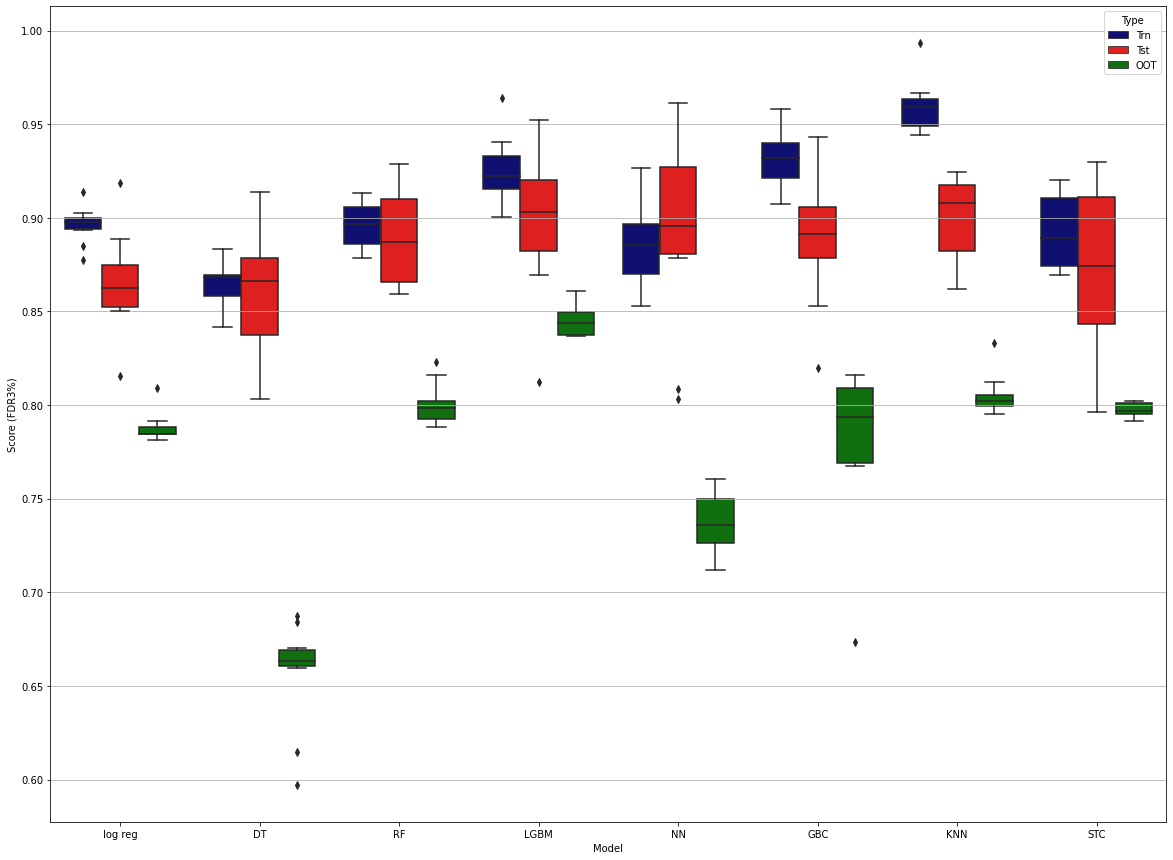

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [55]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:21:17.273338
